In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import plotly.express as px


file_path = 'temp_humidity_co2_logger.txt'
col_names = ["date","co2","temp_c","rel_hum","comment"]
data = pd.read_csv(file_path,delimiter=',',skiprows=2,names=col_names)

data


,date,co2,temp_c,rel_hum,comment
0,2024-01-11T16:25:37.033570,1379.499512,24.930573,27.566528,NaN
1,2024-01-11T16:25:47.951856,1381.997192,24.914551,27.622986,opened
2,2024-01-11T16:26:18.076117,1402.403442,24.647514,26.037598,NaN
3,2024-01-11T16:26:48.205757,1281.721436,24.407188,25.686646,NaN
4,2024-01-11T16:27:18.315896,1266.027466,24.292366,26.428223,NaN
...,...,...,...,...,...
730,2024-01-12T13:00:26.707914,1048.659180,21.136032,30.867004,NaN
731,2024-01-12T13:00:56.837755,1059.897461,21.010529,31.283569,NaN
732,2024-01-12T13:01:26.972539,1077.555908,20.954453,30.960083,NaN
733,2024-01-12T13:01:57.078903,1003.045776,20.812927,30.574036,NaN


My buttons pressing was very incosistent in comparison with the measuremnts away from window. So here i'm dividing measurments into pieces manually, by looking on the shape of line. The approach is quite robust, which is showed in "away_from_window" notebook. 

In [9]:
data['comment'] = float('nan')


In [18]:
data['in_seconds'] = data['date'].dt.second + data['date'].dt.minute*60 + data['date'].dt.hour*3600 + data['date'].dt.day*3600*24
data['in_seconds'] = data['in_seconds'] -data['in_seconds'][0]

In [19]:
data['co2'] = pd.to_numeric(data['co2'], errors='coerce')
data['date'] = pd.to_datetime(data['date']).dt.floor('S')
#data.reset_index(inplace=True, drop=False)

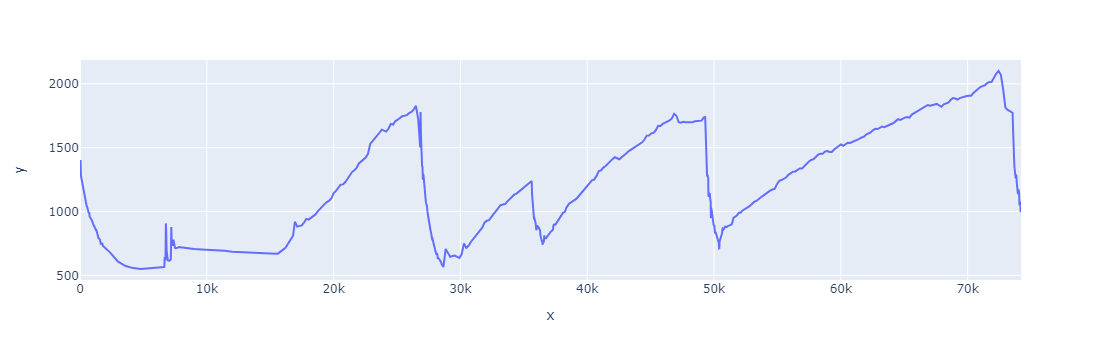

In [20]:
px.line(x=data['in_seconds'],y=data["co2"])

In [22]:
opened_intervals = [(0,3000),(26496,28478),(35621,36434),(49302,50387),(72440,74119)]
closed_intervals = [(15604,26496),(29740,35621),(36562,47036),(50417,72440)]

In [52]:
opening_lines = []
closing_lines = []
for interval in opened_intervals:
    subset = data.loc[(data['in_seconds'] >= interval[0]) & (data['in_seconds'] <= interval[1])]
    koefs = np.polyfit(subset['in_seconds'], subset["co2"], deg=1)
    length = interval[1] - interval[0]
    opening_lines.append({'k':koefs[0]*60, "length":length})# converting seconds to minutes
    print("k: {},b: {}".format(*koefs))
print("-"*40)
for interval in closed_intervals:
    subset = data.loc[(data['in_seconds'] >= interval[0]) & (data['in_seconds'] <= interval[1])]
    koefs = np.polyfit(subset['in_seconds'], subset["co2"], deg=1)
    length = interval[1] - interval[0]
    closing_lines.append({'k':koefs[0]*60,"length":length}) # converting seconds to minutes
    print("k: {},b: {}".format(*koefs))

k: -0.2806859808629235,b: 1225.2359508535503
k: -0.6090383462977957,b: 17778.62118268182
k: -0.3950340447474611,b: 15144.276762648584
k: -0.7443337988846984,b: 38142.513264590045
k: -0.6811188509068812,b: 51584.51461752717
----------------------------------------
k: 0.10927609916844001,b: -1027.519272610879
k: 0.10260679322512875,b: -2388.1658858777214
k: 0.09566660300791348,b: -2676.241669037625
k: 0.05614653923752977,b: -1935.9251142843896


In [53]:
opening_lines

[{'k': -16.84115885177541, 'length': 3000},
 {'k': -36.542300777867744, 'length': 1982},
 {'k': -23.70204268484767, 'length': 813},
 {'k': -44.660027933081906, 'length': 1085},
 {'k': -40.86713105441287, 'length': 1679}]

In [44]:
closing_lines

[{'k': 6.556565950106401, 'length': 10892},
 {'k': 6.156407593507725, 'length': 5881},
 {'k': 5.739996180474809, 'length': 10474},
 {'k': 3.368792354251786, 'length': 22023}]

In [54]:
sleeping_k = closing_lines.pop(3)
sleeping_k

{'k': 3.368792354251786, 'length': 22023}

In [55]:
open_slope = [i['k'] for i in opening_lines]
close_slope = [i['k'] for i in closing_lines]

In [56]:
open_slope_avg = np.mean(open_slope)
open_slope_var = np.var(open_slope)
close_slope_avg = np.mean(close_slope)
close_slope_var = np.var(close_slope)


In [57]:
print(open_slope_avg)
print(close_slope_avg)
ratio = open_slope_avg/(-1*(close_slope_avg))
print(ratio)

-32.52253226039712
6.150989908029644
5.287365569880298


So, the ratio is around 5, which is quite comparable with the ratio, when sensor was away from window (4.5)

So for calculations i will count with a ratio 1:5, which is by some magic is great for making a practical suggestion:
**each hour open a window for 10 minutes**

In [58]:
# harmful concentration during sleep = 1900
# concentariton of co2 was never lower than 500, so let's suppose its a lowest possible
#Question: if i properly ventilate my room, can i sleep with closed windows? 

#Volume of my room: 2,4(height)* 3,6 * 3,5  = 30,24 m3
#bed, table, furniture take around 2m3 of space - > total free space = 28,2 m3
co2_rate_during_sleep = 3.39 # from "near_window" notebook
co2_raise_per_m3 = co2_rate_during_sleep*28.2
co2_conc_fresh = 500
co2_conc_sleep_harmful = 1900
volume = 28.2

#in my case:
max_nonharmful_time = (co2_conc_sleep_harmful-co2_conc_fresh)/(co2_raise_per_m3/volume)
print(f"I can sleep with closed window at max {max_nonharmful_time/60}") # in hours
#But i live in dorm, in case you don't live in dwarfs house, than you  will probably dont exceed it, but if your area is comparable,
#than consider sleeping with open window at least part of a night.

I can sleep with closed window at max 6.882989183874139
